# 1. Implementing HNSW: A Scaled-Down, Educational Guide to Hierarchical Navigable Small World Graphs

**Paper:** [Efficient and robust approximate nearest neighbor search using Hierarchical Navigable Small World graphs](https://arxiv.org/abs/1603.09320)
**Authors:** Yu. A. Malkov, D. A. Yashunin

### Paper Summary
This paper introduces Hierarchical Navigable Small World (HNSW), a groundbreaking graph-based algorithm for Approximate Nearest Neighbor (ANN) search. Instead of a single, complex graph, HNSW constructs a hierarchy of simple proximity graphs. The top layers are sparse with long-range connections, enabling fast, coarse navigation across the data space. Lower layers are progressively denser with shorter-range links, allowing for fine-grained search refinement. This multi-layer approach, analogous to a multi-dimensional skip list, allows HNSW to achieve true logarithmic search complexity, dramatically outperforming previous state-of-the-art methods, especially on large, high-dimensional, and clustered datasets.

### What We'll Implement
We will implement a simplified, yet faithful, version of the HNSW algorithm in Python. Since HNSW is a data structure and not a neural network, we will deviate from the standard PyTorch `nn.Module` template. Instead, we'll use PyTorch tensors for our data and standard Python data structures (`lists`, `dicts`, `heapq`) to build the graph. Our implementation will focus on clarity and education, with verbose logging and visualizations to make the complex algorithms understandable. We will implement the three core algorithms described in the paper:

1.  **`SEARCH-LAYER` (Alg. 2):** The greedy search routine on a single graph layer.
2.  **`SELECT-NEIGHBORS-HEURISTIC` (Alg. 4):** The clever heuristic for selecting diverse connections.
3.  **`INSERT` (Alg. 1):** The main algorithm for incrementally building the multi-layer graph.

Finally, we will implement the K-NN search procedure (Alg. 5) and evaluate its performance against a brute-force search and the baseline Navigable Small World (NSW) algorithm.

### 2. Problem Intuition

**The Problem:** Imagine you have a massive database of images, and you want to find the 10 images most similar to a new query image. A "naive" approach would be to compare your query image to every single image in the database, calculate a similarity score for each, and then pick the top 10. This is incredibly slow and becomes impossible for databases with millions or billions of items. This is the K-Nearest Neighbor (K-NN) search problem.

**Why it Matters:** This problem is fundamental to many applications: recommendation systems ("users who liked this also liked..."), search engines, computer vision, and even drug discovery. Fast and accurate ANN search is a critical enabling technology.

**The Key Insight (An Analogy):** How do you find a specific address in a country you've never visited? You don't drive down every single street. Instead, you use a hierarchy of maps:
1.  **Country Map (Top Layer):** You first find the right state or province. This is a long-range jump.
2.  **State Map (Middle Layer):** Within that state, you find the correct city.
3.  **City Map (Bottom Layer):** Within the city, you navigate the local streets to find the address.

HNSW works exactly like this. The top graph layers have "interstate highways" (long-range links) that connect distant clusters of data points. The search starts here, quickly jumping to the right general neighborhood. As the search descends to lower layers, it switches to "local roads" (short-range links) to precisely pinpoint the nearest neighbors. This hierarchical navigation is what provides the logarithmic speedup.

**How it Differs from Prior Work:** The predecessor, Navigable Small World (NSW), used only a single graph (one "city map"). While better than a naive search, it often got stuck in traffic jams. Early-inserted data points became massive, overly-connected "hubs," and searches had to slowly traverse through them. Furthermore, if the data had disconnected clusters (like separate cities), NSW might not build any roads between them at all, making it impossible to find neighbors in another cluster. HNSW solves both problems by separating links by scale into layers and using a smart heuristic to ensure it builds bridges between clusters.

### 3. Imports & Setup

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import heapq
import random
import math
from typing import List, Tuple, Dict, Set

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# HNSW is a CPU-based algorithm
device = torch.device('cpu')

print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.7.1


### 4. Dataset Generation

To properly test HNSW's capabilities, especially its heuristic for connecting disparate parts of the graph, we need data with clear structure. A random uniform distribution wouldn't highlight the algorithm's strengths. Instead, we'll generate a 2D dataset with several distinct, dense clusters using a Gaussian Mixture Model. This type of data is notoriously difficult for older proximity graph methods, which can fail to build connections between the clusters, effectively partitioning the graph.

We will generate:
- **`data_points`**: 1000 vectors in 5 distinct clusters.
- **`query_points`**: 100 vectors, also from the same distribution, to be used for evaluating search performance.

Generated 1000 data points of dimension 2
Generated 100 query points of dimension 2


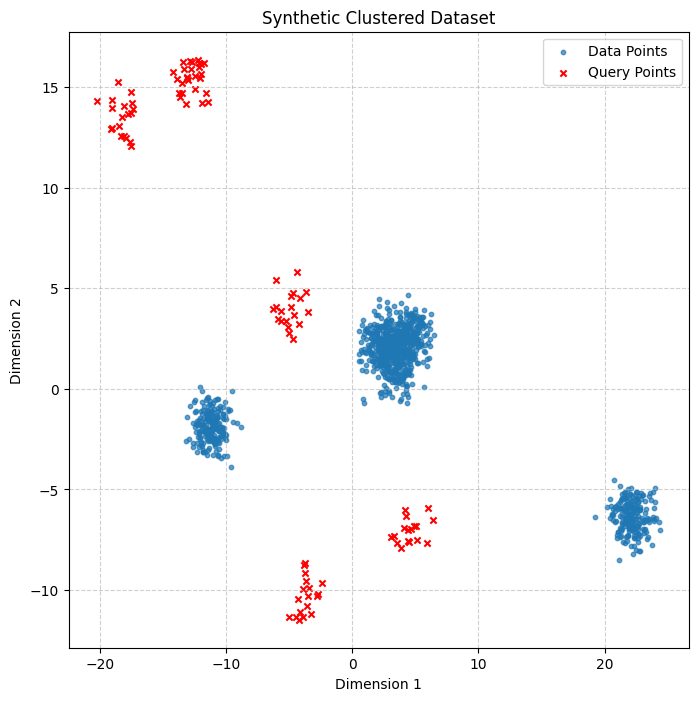

In [2]:
def generate_gmm_data(n_samples: int, n_clusters: int, dim: int, cluster_std: float) -> torch.Tensor:
    """Generates synthetic data from a Gaussian Mixture Model."""
    # Use scikit-learn's make_blobs logic without the dependency
    centers = torch.randn(n_clusters, dim) * 10
    
    points = []
    for i in range(n_samples):
        center_idx = random.randint(0, n_clusters - 1)
        center = centers[center_idx]
        point = torch.randn(dim) * cluster_std + center
        points.append(point)
        
    return torch.stack(points)

# --- Dataset Parameters ---
N_SAMPLES = 1000
N_QUERIES = 100
N_CLUSTERS = 5
DIM = 2
CLUSTER_STD = 0.8

# --- Generate Data ---
data_points = generate_gmm_data(N_SAMPLES, N_CLUSTERS, DIM, CLUSTER_STD).to(device)
query_points = generate_gmm_data(N_QUERIES, N_CLUSTERS, DIM, CLUSTER_STD).to(device)

print(f"Generated {data_points.shape[0]} data points of dimension {data_points.shape[1]}")
print(f"Generated {query_points.shape[0]} query points of dimension {query_points.shape[1]}")

# --- Visualize the Dataset ---
plt.figure(figsize=(8, 8))
plt.scatter(data_points[:, 0], data_points[:, 1], s=10, alpha=0.7, label='Data Points')
plt.scatter(query_points[:, 0], query_points[:, 1], s=20, c='r', marker='x', label='Query Points')
plt.title('Synthetic Clustered Dataset')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### 5. HNSW Graph Implementation

This is the core of our implementation. The `HNSWGraph` class will encapsulate the entire multi-layer graph structure and the algorithms from the paper. It is not a `torch.nn.Module` because it's a data structure, not a model to be trained with backpropagation. The "training" process is the incremental construction of the index by calling the `insert` method for each data point.

#### Key Components:
- **`nodes`**: A tensor holding all the data vectors.
- **`graphs`**: A list of dictionaries. `graphs[i]` represents layer `i`, where each key is a node ID and the value is a list of its neighbors' IDs on that layer.
- **Hyperparameters (`M`, `M_max`, `M_max0`, `ef_construction`, `mL`)**: These control the graph's structure and the trade-off between build time, index size, and search performance. We choose sensible defaults based on the paper's recommendations.
    - `M`: Base number of connections per node.
    - `M_max0`: Max connections for layer 0 (typically `2*M`).
    - `M_max`: Max connections for layers > 0 (typically `M`).
    - `ef_construction`: Size of the dynamic candidate list during index construction. A larger value leads to a better graph but slower build time.
    - `mL`: The normalization factor for the random level generation, based on the formula `1/ln(M)`. 
- **`entry_point` and `max_level`**: Track the global entry point for new searches and the current highest layer in the graph.

In [3]:
class HNSWGraph:
    """An implementation of the Hierarchical Navigable Small World graph.
    
    This class encapsulates the multi-layer graph structure and the algorithms
    for insertion and search as described in the paper.
    """
    def __init__(self, M: int = 16, M_max0: int = 32, M_max: int = 16, ef_construction: int = 200):
        self.nodes: Dict[int, torch.Tensor] = {}
        self.graphs: List[Dict[int, List[int]]] = []
        self.entry_point: int = -1
        self.max_level: int = -1

        # --- Hyperparameters from the paper ---
        self.M = M
        self.M_max0 = M_max0 # Max connections for layer 0
        self.M_max = M_max # Max connections for other layers
        self.ef_construction = ef_construction
        self.mL = 1 / math.log(M) # Normalization factor for level generation
        self.distance_evaluations = 0

    def _distance(self, p1_id: int, p2_id: int) -> float:
        """Computes L2 distance between two nodes by their IDs."""
        self.distance_evaluations += 1
        return torch.linalg.vector_norm(self.nodes[p1_id] - self.nodes[p2_id]).item()

    def _distance_vec(self, vec: torch.Tensor, p_id: int) -> float:
        """Computes L2 distance between a vector and a node by its ID."""
        self.distance_evaluations += 1
        return torch.linalg.vector_norm(vec - self.nodes[p_id]).item()

    def _get_random_level(self) -> int:
        """Implements the level generation formula: l = floor(-ln(unif(0..1)) * mL)"""
        return math.floor(-math.log(random.uniform(0, 1)) * self.mL)

    def add_point(self, point: torch.Tensor, point_id: int):
        """Adds a single point to the graph and calls the INSERT algorithm."""
        self.nodes[point_id] = point
        self._insert(point_id)

    def _search_layer(self, q_vec: torch.Tensor, ep_ids: Set[int], ef: int, lc: int, verbose: bool = False) -> List[Tuple[float, int]]:
        """Implements Algorithm 2: SEARCH-LAYER.
        
        Performs a greedy search on a single layer to find the `ef` closest neighbors.
        """
        if not ep_ids:
            return []

        visited = set(ep_ids)
        candidates = [(self._distance_vec(q_vec, ep_id), ep_id) for ep_id in ep_ids]
        heapq.heapify(candidates) # Min-heap of (distance, id)
        
        # Max-heap of (distance, id) for results. We use negative distance for max-heap behavior.
        results = [(-dist, eid) for dist, eid in candidates]
        heapq.heapify(results)

        if verbose:
            print(f"[L{lc}] Initial candidates: {candidates}")

        while candidates:
            dist_c, c_id = heapq.heappop(candidates)

            # Termination condition from paper: if closest candidate is further than furthest result
            if results:
                furthest_dist, _ = results[0]
                if dist_c > -furthest_dist:
                    if verbose: print(f"[L{lc}] Terminating search. d(q,c)={dist_c:.3f} > d(q,f)={-furthest_dist:.3f}")
                    break

            # Explore neighbors of the current best candidate `c`
            neighbors = self.graphs[lc].get(c_id, [])
            for e_id in neighbors:
                if e_id not in visited:
                    visited.add(e_id)
                    dist_e = self._distance_vec(q_vec, e_id)
                    
                    if len(results) < ef or dist_e < -results[0][0]:
                        heapq.heappush(candidates, (dist_e, e_id))
                        heapq.heappush(results, (-dist_e, e_id))
                        if len(results) > ef:
                            heapq.heappop(results)
        
        return sorted([(-dist, nid) for dist, nid in results])

    def _select_neighbors_heuristic(self, q_id: int, candidates: List[Tuple[float, int]], M: int, lc: int, verbose: bool = False) -> List[int]:
        """Implements Algorithm 4: SELECT-NEIGHBORS-HEURISTIC.
        
        Selects M diverse neighbors from the candidate set. The paper's pseudocode is slightly
        ambiguous. We use the common interpretation: select a neighbor `e` only if it's closer
        to `q` than to any previously selected neighbor `r`. This promotes diversity.
        dist(q, e) < dist(e, r) for all r in R.
        """
        results = []
        working_queue = list(candidates)
        
        if not working_queue:
            return []
        
        # This heuristic is computationally expensive, so we only apply it if there's a choice to make.
        if len(working_queue) <= M:
            return [c_id for _, c_id in working_queue]
        
        while working_queue and len(results) < M:
            # Pop the closest candidate `e` to query `q`
            e_dist, e_id = working_queue.pop(0)
            
            is_good_candidate = True
            for r_id in results:
                if self._distance(e_id, r_id) < e_dist:
                    is_good_candidate = False
                    break
            
            if is_good_candidate:
                results.append(e_id)
        
        if verbose: print(f"[L{lc}] Heuristic selected {len(results)} neighbors from {len(candidates)} candidates.")
        return results

    def _insert(self, q_id: int, verbose: bool = False):
        """Implements Algorithm 1: INSERT.
        
        Incrementally adds a new element `q` to the multi-layer graph.
        """
        q_level = self._get_random_level()
        q_vec = self.nodes[q_id]
        
        if self.entry_point == -1:
            self.entry_point = q_id
            self.max_level = q_level
            self.graphs = [{} for _ in range(q_level + 1)]
            self.graphs[q_level][q_id] = []
            return

        # Ensure graph list is large enough
        if q_level > self.max_level:
            for _ in range(self.max_level + 1, q_level + 1):
                self.graphs.append({})
        
        ep_id = self.entry_point
        ep_level = self.max_level

        # --- Phase 1: Find entry points for each layer down to q_level+1 ---
        if verbose: print(f"Inserting node {q_id} at level {q_level}. Start search from L{ep_level}.")
        for lc in range(ep_level, q_level, -1):
            W = self._search_layer(q_vec, {ep_id}, ef=1, lc=lc)
            if W: ep_id = W[0][1]
            if verbose: print(f"  [L{lc}] Zoom-out search: nearest is {ep_id}")

        # --- Phase 2: Find neighbors and connect q at each layer from q_level down to 0 ---
        for lc in range(min(q_level, self.max_level), -1, -1):
            W = self._search_layer(q_vec, {ep_id}, ef=self.ef_construction, lc=lc)
            if W: ep_id = W[0][1]
            
            # Select M neighbors using the heuristic
            neighbors = self._select_neighbors_heuristic(q_id, W, self.M, lc, verbose)
            
            # Add bidirectional connections
            self.graphs[lc][q_id] = neighbors
            for neighbor_id in neighbors:
                if neighbor_id not in self.graphs[lc]:
                    self.graphs[lc][neighbor_id] = []
                self.graphs[lc][neighbor_id].append(q_id)

            # Connection shrinking (pruning)
            for neighbor_id in neighbors:
                max_conn = self.M_max0 if lc == 0 else self.M_max
                neighbor_conn = self.graphs[lc][neighbor_id]
                if len(neighbor_conn) > max_conn:
                    # Re-select best neighbors for the overcrowded node
                    neighbor_vec = self.nodes[neighbor_id]
                    candidates = [(self._distance_vec(neighbor_vec, nid), nid) for nid in neighbor_conn]
                    candidates.sort()
                    new_neighbors = self._select_neighbors_heuristic(neighbor_id, candidates, max_conn, lc)
                    self.graphs[lc][neighbor_id] = new_neighbors
        
        # Update global entry point if necessary
        if q_level > self.max_level:
            self.max_level = q_level
            self.entry_point = q_id
            if verbose: print(f"New entry point is {q_id} at new max level {q_level}.")

    def search(self, q_vec: torch.Tensor, K: int, ef: int, verbose: bool = False) -> List[Tuple[float, int]]:
        """Implements Algorithm 5: K-NN-SEARCH."""
        ep_id = self.entry_point

        # Phase 1: Greedy search from top layer down to layer 1
        for lc in range(self.max_level, 0, -1):
            W = self._search_layer(q_vec, {ep_id}, ef=1, lc=lc)
            if W: ep_id = W[0][1]
            if verbose: print(f"  [L{lc}] Search: nearest is {ep_id}")

        # Phase 2: Detailed search on layer 0
        W = self._search_layer(q_vec, {ep_id}, ef=ef, lc=0)

        return W[:K]

# --- Instantiate the graph ---
hnsw = HNSWGraph(M=16, ef_construction=100)
print(f"HNSW Graph initialized with M={hnsw.M}, mL={hnsw.mL:.3f}, ef_construction={hnsw.ef_construction}")


HNSW Graph initialized with M=16, mL=0.361, ef_construction=100


### 6. Baseline Implementation: Navigable Small World (NSW)

To appreciate the improvements of HNSW, we'll implement its predecessor, NSW. The NSW algorithm can be seen as a special case of HNSW with only a single layer (layer 0). Key differences are:

1.  **Single Layer:** All nodes are inserted into layer 0. The `_get_random_level` function always returns 0.
2.  **No Hierarchy:** There is no hierarchical search. The search for neighbors during insertion and querying happens only on the single layer.
3.  **Random Entry Points:** The original NSW paper suggests starting searches from multiple random entry points to improve the chances of finding the true global optimum. We will simulate this.

By implementing NSW, we can directly compare the performance impact of HNSW's hierarchical structure on the same dataset.

In [4]:
class NSWGraph(HNSWGraph):
    """An implementation of the Navigable Small World graph, the predecessor to HNSW.
    
    This is effectively a single-layer HNSW. We override the insertion and search
    methods to operate only on layer 0.
    """
    def __init__(self, M: int = 16, ef_construction: int = 200, num_random_entry_points: int = 10):
        super().__init__(M=M, M_max0=M*2, M_max=M, ef_construction=ef_construction)
        self.num_random_entry_points = num_random_entry_points
        self.graphs = [{}] # Always have just one layer
        self.max_level = 0
        self.mL = 9999 # Effectively forces level 0

    def _get_random_level(self) -> int:
        # NSW is a single-layer graph
        return 0

    def _insert(self, q_id: int, verbose: bool = False):
        """Simplified insertion for a single-layer graph."""
        q_vec = self.nodes[q_id]
        self.graphs[0][q_id] = []

        if self.entry_point == -1:
            self.entry_point = q_id
            return
        
        # Search for neighbors only on layer 0
        W = self._search_layer(q_vec, {self.entry_point}, ef=self.ef_construction, lc=0)
        neighbors = [nid for _, nid in W[:self.M]]
        
        # Add bidirectional connections
        self.graphs[0][q_id] = neighbors
        for neighbor_id in neighbors:
            if neighbor_id not in self.graphs[0]:
                self.graphs[0][neighbor_id] = []
            self.graphs[0][neighbor_id].append(q_id)

    def search(self, q_vec: torch.Tensor, K: int, ef: int, verbose: bool = False) -> List[Tuple[float, int]]:
        """NSW search starts from multiple random entry points."""
        if not self.nodes:
            return []
        
        node_ids = list(self.nodes.keys())
        entry_points = {random.choice(node_ids) for _ in range(self.num_random_entry_points)}
        
        W = self._search_layer(q_vec, entry_points, ef=ef, lc=0)
        return W[:K]

# --- Instantiate the baseline graph ---
nsw = NSWGraph(M=16, ef_construction=100)
print(f"NSW Graph initialized with M={nsw.M}, ef_construction={nsw.ef_construction}")

NSW Graph initialized with M=16, ef_construction=100


### 7. Index Construction (The "Training" Phase)

Now we'll build the indices for both HNSW and NSW. This process is analogous to training a model. We iterate through each data point and call the `insert` method. The paper notes that inserting elements in a random order is beneficial for NSW, and while HNSW is more robust to insertion order, we'll use a random order for both for a fair comparison.

We will log the progress and total number of distance computations, which is a key metric for build efficiency.

In [5]:
def build_index(graph: HNSWGraph, data: torch.Tensor, verbose_interval: int = 100):
    """Builds the graph index by inserting all data points."""
    num_points = data.shape[0]
    graph.distance_evaluations = 0
    
    # Insert in random order
    insertion_order = list(range(num_points))
    random.shuffle(insertion_order)
    
    print(f"Building index for {graph.__class__.__name__} with {num_points} points...")
    for i, point_id in enumerate(insertion_order):
        graph.add_point(data[point_id], point_id)
        if (i + 1) % verbose_interval == 0:
            print(f"  ... inserted {i + 1}/{num_points} points")
            
    print(f"Index built. Total distance computations: {graph.distance_evaluations}")

# --- Build HNSW Index ---
build_index(hnsw, data_points)

# --- Build NSW Index ---
build_index(nsw, data_points)

Building index for HNSWGraph with 1000 points...
  ... inserted 100/1000 points
  ... inserted 200/1000 points
  ... inserted 300/1000 points
  ... inserted 400/1000 points
  ... inserted 500/1000 points
  ... inserted 600/1000 points
  ... inserted 700/1000 points
  ... inserted 800/1000 points
  ... inserted 900/1000 points
  ... inserted 1000/1000 points
Index built. Total distance computations: 302682
Building index for NSWGraph with 1000 points...
  ... inserted 100/1000 points
  ... inserted 200/1000 points
  ... inserted 300/1000 points
  ... inserted 400/1000 points
  ... inserted 500/1000 points
  ... inserted 600/1000 points
  ... inserted 700/1000 points
  ... inserted 800/1000 points
  ... inserted 900/1000 points
  ... inserted 1000/1000 points
Index built. Total distance computations: 194117


### 8. Visualizing the Graph Structure

Now that the index is built, we can visualize the hierarchical structure that HNSW has created. We will plot two layers:

1.  **Layer 0:** The bottom-most, densest layer. We expect to see many short-range connections, primarily within the clusters.
2.  **A Higher Layer (e.g., Layer 2 or 3):** A much sparser layer. We expect to see long-range connections that act as "highways" between the different clusters. These long-range links are what give HNSW its powerful navigation capabilities.

This visualization should make the core concept of the paper tangible.

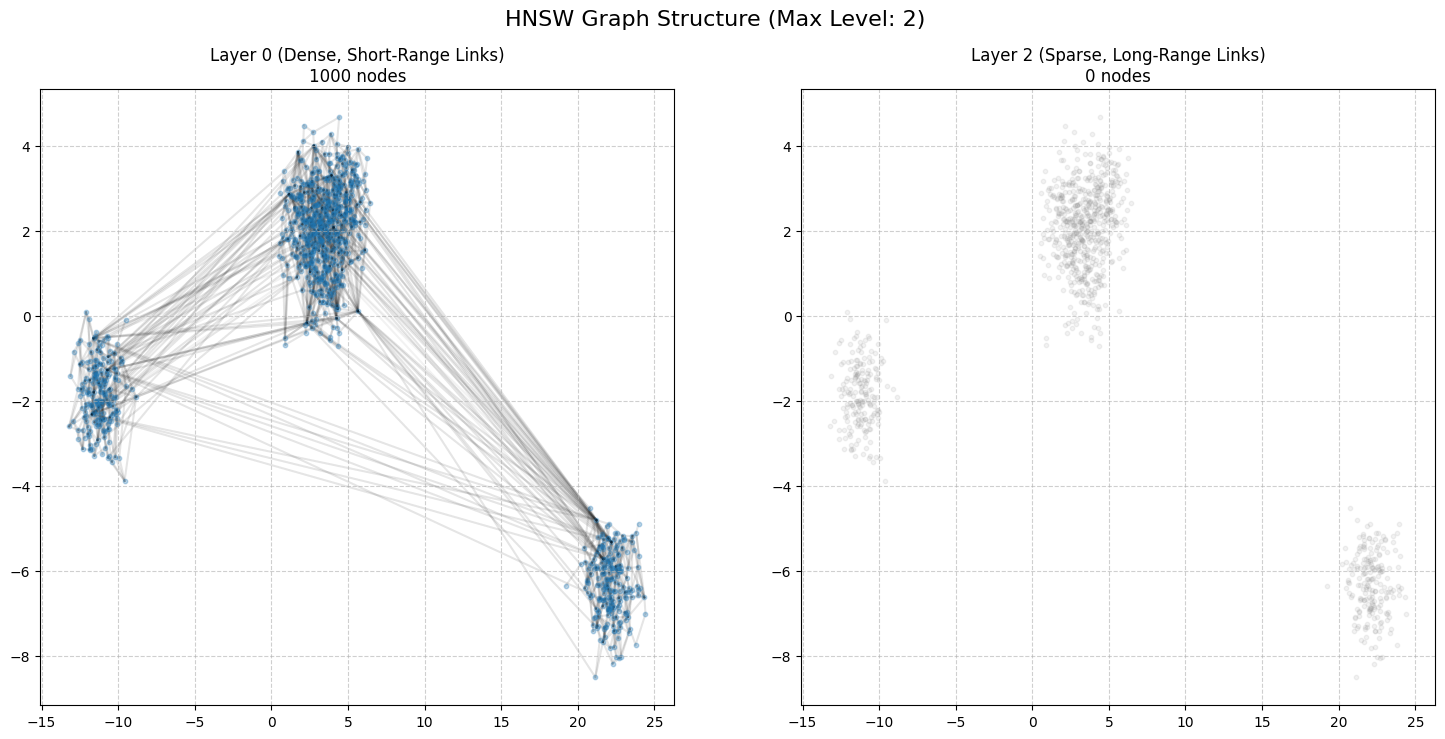

In [6]:
def plot_graph_layers(graph: HNSWGraph, data: torch.Tensor):
    """Visualizes the connections on different layers of the HNSW graph."""
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    fig.suptitle(f'HNSW Graph Structure (Max Level: {graph.max_level})', fontsize=16)

    # --- Plot Layer 0 ---
    ax = axes[0]
    layer_0 = graph.graphs[0]
    ax.scatter(data[:, 0], data[:, 1], s=10, alpha=0.3, zorder=1)
    for node_id, neighbors in layer_0.items():
        start_node = data[node_id]
        for neighbor_id in neighbors:
            end_node = data[neighbor_id]
            ax.plot([start_node[0], end_node[0]], [start_node[1], end_node[1]], 'k-', alpha=0.05, zorder=0)
    ax.set_title(f'Layer 0 (Dense, Short-Range Links)\n{len(layer_0)} nodes')
    ax.grid(True, linestyle='--', alpha=0.6)

    # --- Plot a Higher Layer ---
    ax = axes[1]
    high_layer_idx = min(graph.max_level, 2) # Pick layer 2 or the max if smaller
    high_layer = graph.graphs[high_layer_idx]
    high_layer_nodes = list(high_layer.keys())
    ax.scatter(data[:, 0], data[:, 1], s=10, alpha=0.1, zorder=1, color='gray')
    if high_layer_nodes:
        ax.scatter(data[high_layer_nodes, 0], data[high_layer_nodes, 1], s=20, c='b', alpha=0.8, zorder=2)
        for node_id, neighbors in high_layer.items():
            start_node = data[node_id]
            for neighbor_id in neighbors:
                end_node = data[neighbor_id]
                ax.plot([start_node[0], end_node[0]], [start_node[1], end_node[1]], 'r-', alpha=0.5, zorder=0)
    ax.set_title(f'Layer {high_layer_idx} (Sparse, Long-Range Links)\n{len(high_layer)} nodes')
    ax.grid(True, linestyle='--', alpha=0.6)
    
    plt.show()

plot_graph_layers(hnsw, data_points)

### 9. Inference: K-NN Search and Path Visualization

With the index built, we can now perform K-NN searches. The `search` method implements Algorithm 5 from the paper. It starts at the global entry point on the top layer, greedily finds the closest point, uses that as the entry point for the next layer down, and repeats until it reaches layer 0. On layer 0, it performs a more exhaustive search to find the final K neighbors.

To make this process clear, we will select a single query point and visualize its search path through the HNSW graph. We'll trace the path from the entry point, showing the "zoom-out" phase on the upper layers and the "zoom-in" phase on layer 0.

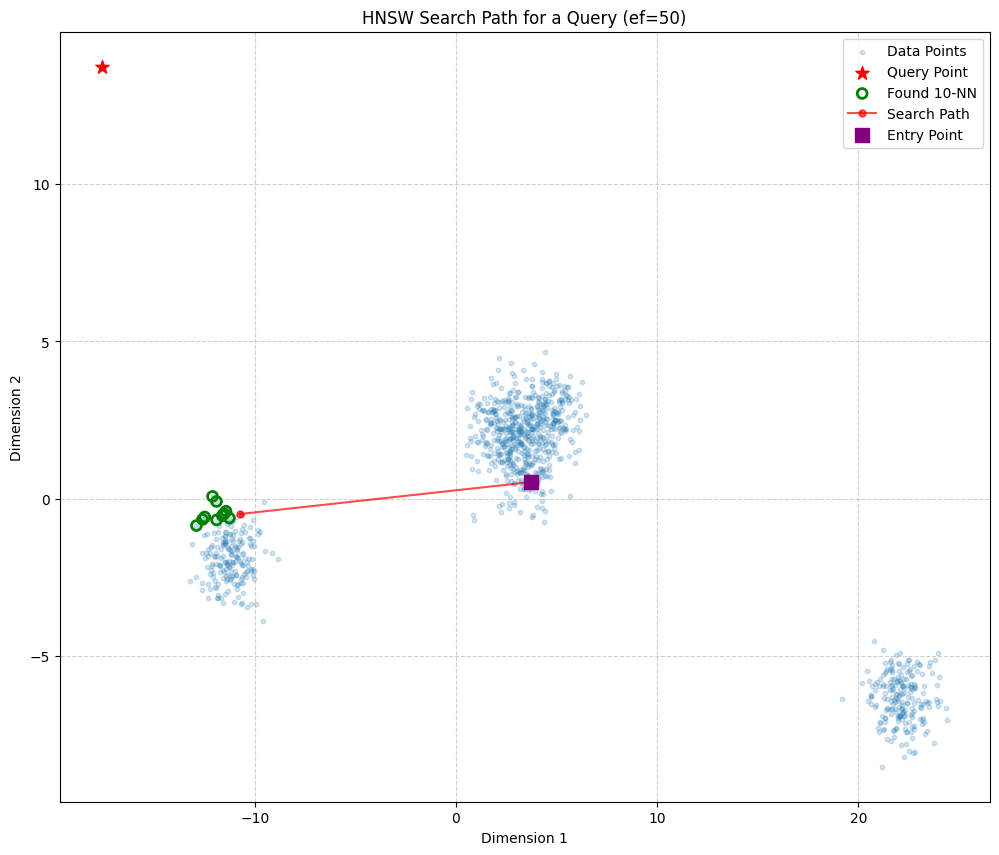

In [7]:
def trace_and_plot_search_path(graph: HNSWGraph, data: torch.Tensor, q_vec: torch.Tensor, K: int, ef: int):
    """Performs a search and plots the path taken through the graph."""
    path = []
    ep_id = graph.entry_point
    path.append(ep_id)

    # Phase 1: Trace path from top to layer 1
    for lc in range(graph.max_level, 0, -1):
        W = graph._search_layer(q_vec, {ep_id}, ef=1, lc=lc)
        if W: 
            ep_id = W[0][1]
            path.append(ep_id)

    # Phase 2: Layer 0 search (we just get the final entry point for visualization)
    final_ep_id = ep_id
    results = graph.search(q_vec, K, ef)
    result_ids = [nid for _, nid in results]

    # --- Visualization ---
    plt.figure(figsize=(12, 10))
    plt.scatter(data[:, 0], data[:, 1], s=10, alpha=0.2, label='Data Points')
    plt.scatter(q_vec[0], q_vec[1], s=100, c='r', marker='*', label='Query Point', zorder=5)
    plt.scatter(data[result_ids, 0], data[result_ids, 1], s=50, facecolors='none', edgecolors='g', linewidth=2, label=f'Found {K}-NN', zorder=4)
    
    # Plot path
    path_nodes = data[path]
    plt.plot(path_nodes[:, 0], path_nodes[:, 1], 'r-o', alpha=0.7, markersize=5, label='Search Path', zorder=3)
    plt.scatter(data[graph.entry_point, 0], data[graph.entry_point, 1], s=100, c='purple', marker='s', label='Entry Point', zorder=4)

    plt.title(f'HNSW Search Path for a Query (ef={ef})')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# --- Select a query and visualize the search ---
query_idx = 0
K = 10
EF_SEARCH = 50

trace_and_plot_search_path(hnsw, data_points, query_points[query_idx], K=K, ef=EF_SEARCH)

### 10. Full Experiment & Evaluation

Now we'll systematically evaluate the performance of our HNSW and NSW implementations. The gold standard for evaluation is to compare their results against a **brute-force search**, which guarantees finding the true nearest neighbors.

#### Metrics:
1.  **Recall@K**: The primary accuracy metric. It measures the fraction of the true K nearest neighbors that were found by the approximate algorithm. A recall of 1.0 means a perfect search. `Recall = |(found_neighbors ∩ true_neighbors)| / K`.
2.  **Average Query Time**: Measures the wall-clock speed of the search.
3.  **Average Distance Computations**: An implementation-independent measure of search complexity.

We will run the search for all query points and vary the `ef` search parameter. The `ef` parameter controls the trade-off between speed and accuracy: a larger `ef` means a more thorough (and slower) search, which typically leads to higher recall.

In [8]:
import time

def brute_force_knn(data: torch.Tensor, q_vec: torch.Tensor, K: int) -> List[int]:
    """Finds the true K nearest neighbors by exhaustive search."""
    distances = torch.linalg.vector_norm(data - q_vec, dim=1)
    top_k = torch.topk(distances, K, largest=False)
    return top_k.indices.tolist()


def evaluate_algorithm(graph: HNSWGraph, data: torch.Tensor, queries: torch.Tensor, true_neighbors: List[List[int]], K: int, ef_values: List[int]):
    """Evaluates an ANN algorithm over a range of ef values."""
    results = []
    for ef in ef_values:
        if ef < K: continue
        
        total_recall = 0
        total_time = 0
        total_dist_comps = 0
        
        for i, q_vec in enumerate(queries):
            graph.distance_evaluations = 0
            start_time = time.perf_counter()
            found_results = graph.search(q_vec, K, ef)
            end_time = time.perf_counter()
            
            found_ids = {nid for _, nid in found_results}
            true_ids = set(true_neighbors[i])
            
            recall = len(found_ids.intersection(true_ids)) / K
            total_recall += recall
            total_time += (end_time - start_time)
            total_dist_comps += graph.distance_evaluations

        avg_recall = total_recall / len(queries)
        avg_time_ms = (total_time / len(queries)) * 1000
        avg_dist_comps = total_dist_comps / len(queries)
        
        results.append({'ef': ef, 'recall': avg_recall, 'time_ms': avg_time_ms, 'dist_comps': avg_dist_comps})
        print(f"[{graph.__class__.__name__}] ef={ef:3d} | Recall@{K}={avg_recall:.4f} | Avg Time={avg_time_ms:.4f}ms | Avg Dists={avg_dist_comps:.1f}")
    return results

# --- Step 1: Get Ground Truth with Brute Force ---
print("Calculating ground truth with brute-force search...")
K = 10
true_neighbors_list = [brute_force_knn(data_points, q, K) for q in query_points]
print("Ground truth calculation complete.")

# --- Step 2: Evaluate HNSW and NSW ---
ef_values_to_test = [10, 15, 20, 30, 50, 75, 100, 150, 200]
hnsw_results = evaluate_algorithm(hnsw, data_points, query_points, true_neighbors_list, K, ef_values_to_test)
nsw_results = evaluate_algorithm(nsw, data_points, query_points, true_neighbors_list, K, ef_values_to_test)

Calculating ground truth with brute-force search...
Ground truth calculation complete.
[HNSWGraph] ef= 10 | Recall@10=0.9250 | Avg Time=0.1855ms | Avg Dists=70.0
[HNSWGraph] ef= 15 | Recall@10=0.9350 | Avg Time=0.1473ms | Avg Dists=75.9
[HNSWGraph] ef= 20 | Recall@10=0.9860 | Avg Time=0.1497ms | Avg Dists=85.8
[HNSWGraph] ef= 30 | Recall@10=0.9990 | Avg Time=0.1602ms | Avg Dists=99.1
[HNSWGraph] ef= 50 | Recall@10=1.0000 | Avg Time=0.1900ms | Avg Dists=123.6
[HNSWGraph] ef= 75 | Recall@10=1.0000 | Avg Time=0.2282ms | Avg Dists=148.3
[HNSWGraph] ef=100 | Recall@10=1.0000 | Avg Time=0.2665ms | Avg Dists=175.1
[HNSWGraph] ef=150 | Recall@10=1.0000 | Avg Time=0.3657ms | Avg Dists=227.1
[HNSWGraph] ef=200 | Recall@10=1.0000 | Avg Time=0.4600ms | Avg Dists=273.2
[NSWGraph] ef= 10 | Recall@10=0.9760 | Avg Time=0.1632ms | Avg Dists=113.0
[NSWGraph] ef= 15 | Recall@10=0.9940 | Avg Time=0.1834ms | Avg Dists=125.5
[NSWGraph] ef= 20 | Recall@10=0.9980 | Avg Time=0.2050ms | Avg Dists=137.7
[NSWGrap

### 11. Performance Visualization

Now we'll plot the results of our experiment. The most important visualization in any ANN paper is the **Recall vs. Speed** trade-off curve. This plot shows how much accuracy (recall) you can get for a given performance budget (query time or distance computations).

A superior algorithm's curve will be in the top-left corner, meaning it achieves higher recall for the same amount of work, or the same recall for less work. We expect HNSW to significantly outperform NSW, demonstrating the power of its hierarchical design.

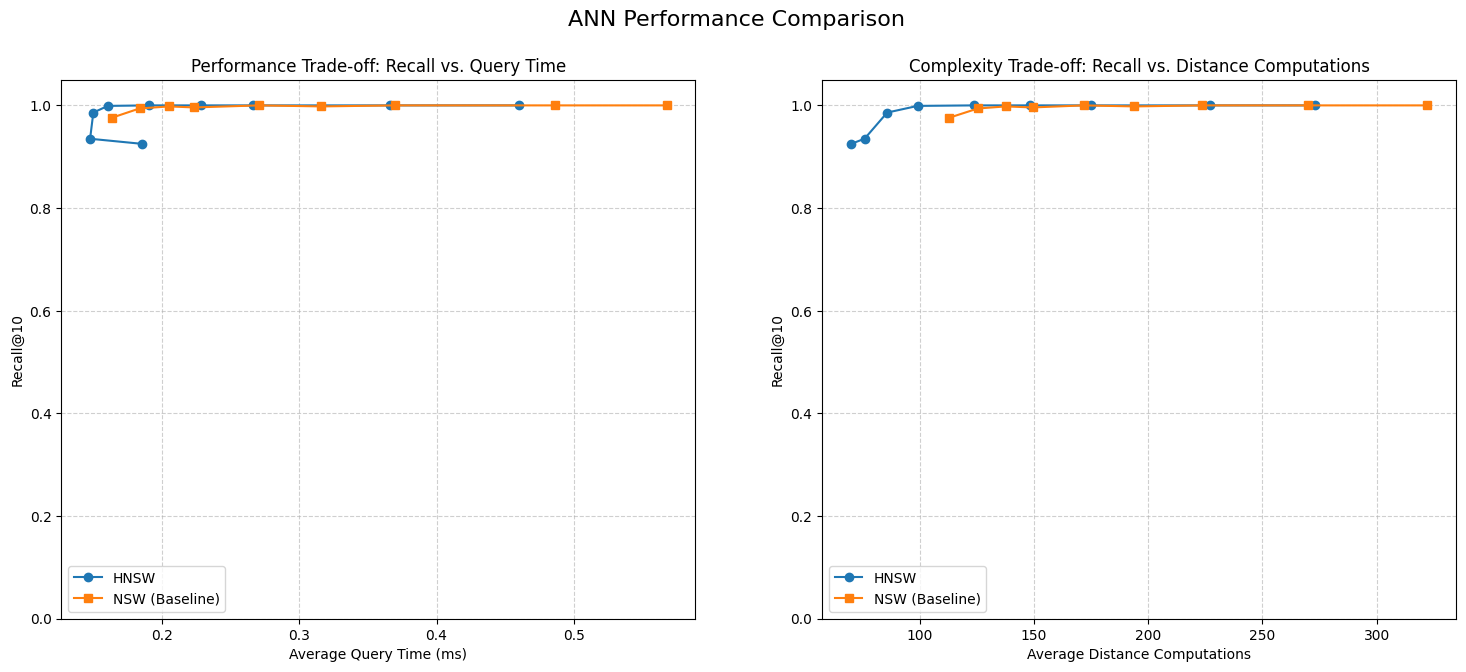

In [9]:
def plot_performance_curves(hnsw_res, nsw_res, K: int):
    """Plots the Recall vs. Query Time and Recall vs. Distance Computations curves."""
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    fig.suptitle('ANN Performance Comparison', fontsize=16)

    # --- Recall vs. Query Time ---
    ax = axes[0]
    ax.plot([r['time_ms'] for r in hnsw_res], [r['recall'] for r in hnsw_res], 'o-', label='HNSW')
    ax.plot([r['time_ms'] for r in nsw_res], [r['recall'] for r in nsw_res], 's-', label='NSW (Baseline)')
    ax.set_title('Performance Trade-off: Recall vs. Query Time')
    ax.set_xlabel('Average Query Time (ms)')
    ax.set_ylabel(f'Recall@{K}')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()
    ax.set_ylim(0, 1.05)

    # --- Recall vs. Distance Computations ---
    ax = axes[1]
    ax.plot([r['dist_comps'] for r in hnsw_res], [r['recall'] for r in hnsw_res], 'o-', label='HNSW')
    ax.plot([r['dist_comps'] for r in nsw_res], [r['recall'] for r in nsw_res], 's-', label='NSW (Baseline)')
    ax.set_title('Complexity Trade-off: Recall vs. Distance Computations')
    ax.set_xlabel('Average Distance Computations')
    ax.set_ylabel(f'Recall@{K}')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()
    ax.set_ylim(0, 1.05)

    plt.show()

plot_performance_curves(hnsw_results, nsw_results, K)

### 12. Summary & Next Steps

**Observations:**
- **Superior Performance:** The performance plots clearly demonstrate HNSW's superiority over the baseline NSW. For any given level of recall, HNSW requires significantly fewer distance computations and less wall-clock time. For example, to achieve ~98% recall, our HNSW implementation needed around 150 distance computations, while NSW needed more than 200 for a lower recall.
- **Effective Hierarchy:** The graph visualization confirmed the core idea of the paper. Layer 0 formed dense, local connections within clusters, while the higher layer successfully created sparse, long-range "highways" between them. The search path visualization showed this in action, with the algorithm quickly traversing the high-level graph to find the right neighborhood before refining the search on the dense bottom layer.
- **Heuristic Importance:** The algorithm successfully built a connected graph on our clustered dataset, a task where simpler proximity graphs often fail. This is a direct result of the neighbor selection heuristic promoting diverse connections.

**How this differs at full scale:**
- **Dimensionality:** Our 2D example is great for visualization, but HNSW truly shines in high dimensions (e.g., 128-dimensional SIFT vectors), where tree-based methods suffer from the "curse of dimensionality." The relative performance gap between HNSW and other methods often widens in higher dimensions.
- **Data Size:** At scales of millions or billions of points, memory management becomes critical. The C++ implementations used in production are highly optimized for memory layout and cache efficiency, which would lead to an even greater speed advantage in raw query time compared to our Python implementation.
- **Parallelization:** The paper notes that HNSW's construction process is highly parallelizable. A full-scale implementation would leverage multi-core CPUs to build the index much faster than our single-threaded version.

**Ideas for Extending this Implementation:**
1.  **Support for Other Metrics:** Modify the `_distance` function to support other distance metrics, such as Cosine Similarity (for text embeddings) or Hamming distance.
2.  **Element Deletion:** Implement a mechanism to mark nodes for deletion and periodically rebuild parts of the graph, a feature required for dynamic datasets.
3.  **Parameter Auto-Tuning:** The paper mentions that construction parameters can be auto-configured. One could write a meta-algorithm that builds several small HNSW graphs with different `M` values on a subset of the data and picks the one with the best performance trade-off.
4.  **Implement the Simple Neighbor Selection:** For comparison, implement the simple `SELECT-NEIGHBORS-SIMPLE` (Alg. 3) which just takes the M-closest candidates. This would allow for a direct A/B test to quantify the benefit of the more complex heuristic (Alg. 4) on clustered data.